<h3>Download dataset from kaggle (uses kaggle username and key)

In [2]:
import opendatasets as od

od.download('https://www.kaggle.com/c/airbus-ship-detection/data')

100%|██████████| 28.6G/28.6G [35:51<00:00, 14.3MB/s]  



Extracting archive ./airbus-ship-detection/airbus-ship-detection.zip to ./airbus-ship-detection


In [1]:
import matplotlib.pyplot as plt
import cv2
import os
import sys
import pandas as pd

sys.path.insert(0, os.path.abspath('..'))
DATA_PATH = os.path.join("..", "data", "airbus-ship-detection")


<h3>Explore csv file

In [2]:
df = pd.read_csv(os.path.join(DATA_PATH, "train_ship_segmentations_v2.csv"))
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [3]:
print('Entries with no ships:', len(df[df['EncodedPixels'].isnull()]))
print('Entries with ships:', len(df[df['EncodedPixels'].notnull()]))
# Data is heavily skewed towards no ship regions, so it would make sense to drop half of the images without ships

Entries with no ships: 150000
Entries with ships: 81723


<h3> Explore ship segmentations

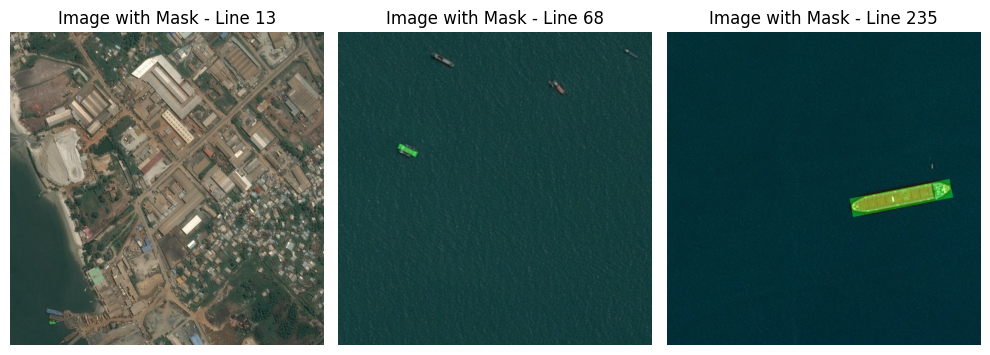

In [4]:
from src.utils import decode_rle, add_mask_to_image


lines = [13, 68, 235]  # indices match line numbers in the csv file
offset_lines = [line - 2 for line in lines]  # adjust for header and 0-indexing
csv_file_path = os.path.join(DATA_PATH, "train_ship_segmentations_v2.csv")
df = pd.read_csv(csv_file_path)

fig, axs = plt.subplots(1, len(lines), figsize=(10, len(lines) * 5), squeeze=False)

for id, line in enumerate(offset_lines):
    row = df.iloc[line]
    image_name, rle_string = row['ImageId'], row['EncodedPixels']
    image_path = os.path.join(DATA_PATH, "train_v2", image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mask = decode_rle(rle_string)
    image_masked = add_mask_to_image(image, mask)
    
    axs[0, id].imshow(image_masked)
    axs[0, id].axis('off')
    axs[0, id].set_title(f'Image with Mask - Line {lines[id]}')

plt.tight_layout()
plt.show()


<h3> Show all ships on image

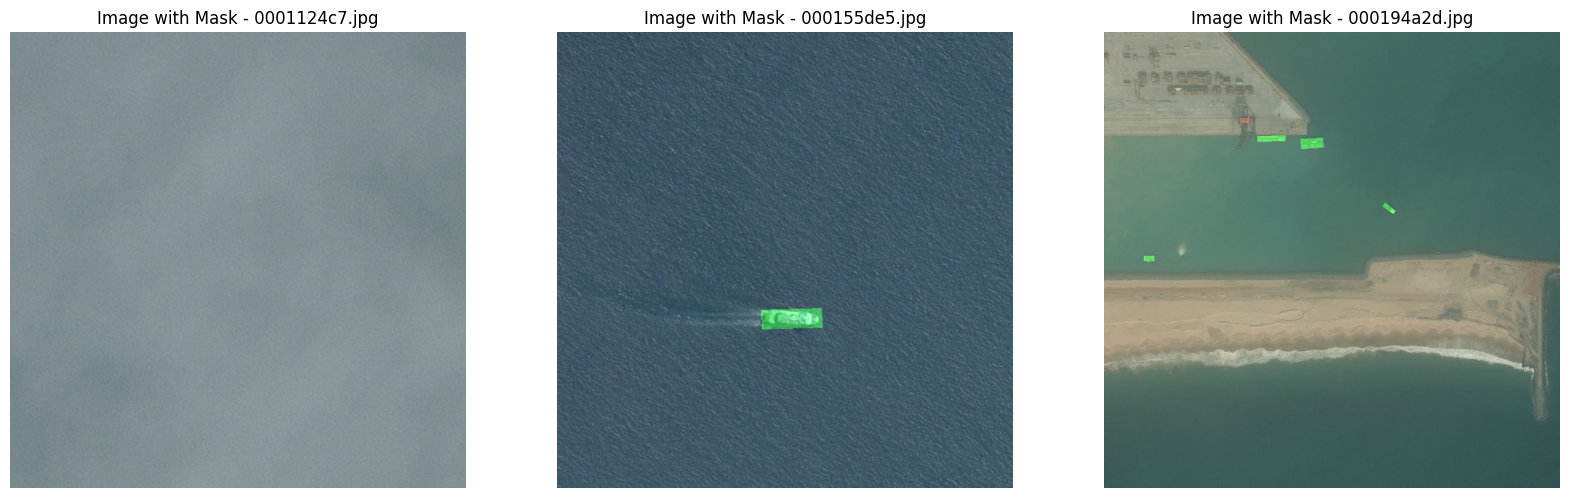

In [5]:
from src.utils import csv_group_by_image, decode_rle, add_mask_to_image

csv_file_path = os.path.join(DATA_PATH, "train_ship_segmentations_v2.csv")

num_of_images_to_display = 3

fig, axs = plt.subplots(1, num_of_images_to_display, figsize=(20, num_of_images_to_display * 10), squeeze=False)

counter = 0
for image_name, row in csv_group_by_image(csv_file_path).iterrows():
    if counter == num_of_images_to_display:
        break
    image_name = image_name
    image_path = os.path.join(DATA_PATH, "train_v2", image_name)

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for rle_string in row['EncodedPixels']:
        if pd.isnull(rle_string):  # skip no ship in the image
            continue
        rle_string = str(rle_string)
        mask = decode_rle(rle_string)
        image = add_mask_to_image(image, mask)

    axs[0, counter].imshow(image)
    axs[0, counter].axis('off')
    axs[0, counter].set_title(f'Image with Mask - {image_name}')
    counter += 1